In [1]:
#!.\dd\Scripts\activate



#Import the necessary libraries needed to build the machine learning model
import tensorflow as tf
from tensorflow import keras as k
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_io as tfio
import tensorflow_datasets as tfds

D:\Drowsiness_detection\dd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
eye_close = 'Ce/Close eye'
eye_open = 'Oe/Eyeopen'

In [3]:
#Converting .heif files to .jpeg files for easier access

#import os
#from PIL import Image, ExifTags
#from pillow_heif import register_heif_opener
#from datetime import datetime
#import piexif
#import re
#register_heif_opener()
#
#def convert_heic_to_jpeg(dir_of_interest):
#        filenames = os.listdir(dir_of_interest)
#        filenames_matched = [re.search("\.HEIC$|\.heic$", filename) for filename in filenames]
#
#        # Extract files of interest
#        HEIC_files = []
#        for index, filename in enumerate(filenames_matched):
#                if filename:
#                        HEIC_files.append(filenames[index])
#        for filename in HEIC_files:
#                image = Image.open(dir_of_interest + "/" + filename)
#                image_exif = image.getexif()
#                if image_exif:
#                        exif = { ExifTags.TAGS[k]: v for k, v in image_exif.items() if k in ExifTags.TAGS and type(v) is not bytes }
#                        date = datetime.strptime(exif['DateTime'], '%Y:%m:%d %H:%M:%S')
#
#                        # Load exif data via piexif
#                        exif_dict = piexif.load(image.info["exif"])
#
#                        # Update exif data with orientation and datetime
#                        exif_dict["0th"][piexif.ImageIFD.DateTime] = date.strftime("%Y:%m:%d %H:%M:%S")
#                        exif_dict["0th"][piexif.ImageIFD.Orientation] = 1
#                        exif_bytes = piexif.dump(exif_dict)
#
#                        
#                        image.save(dir_of_interest + "/" + os.path.splitext(filename)[0] + ".jpg", "jpeg", exif= exif_bytes)
#                else:
#                        print(f"Unable to get exif data for {filename}")
#

In [4]:
#convert_heic_to_jpeg(eye_close)

In [5]:
#convert_heic_to_jpeg(eye_open)

In [6]:
#image readings
import cv2

In [7]:
open_eyes = []
closed_eyes = []

def get_images(dir_list,flag):
    count = 0
    for i in os.listdir(dir_list):
        if i[-4:] == "HEIC":
            continue
        else:
            if flag == 1:
                open_eyes.append(eye_open + "/" + i)
            else:
                closed_eyes.append(eye_close + "/" +i)
                
get_images(eye_open,1)
get_images(eye_close, 0)

In [8]:
len(open_eyes)

51

In [9]:
len(closed_eyes)

52

In [10]:
#loading to test
img = cv2.imread(closed_eyes[42])

In [11]:
#resizing

img = cv2.resize(img, (40,40))

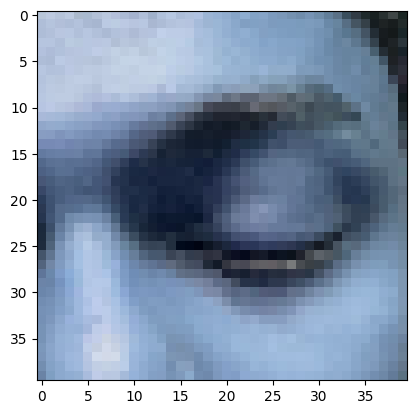

In [12]:
#check
plt.imshow(img)

In [13]:
oe = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(open_eyes),
                          tf.data.Dataset.from_tensor_slices(tf.zeros(len(open_eyes)))))

ce = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(closed_eyes), 
                          tf.data.Dataset.from_tensor_slices(tf.ones(len(closed_eyes)))))

final_df = oe.concatenate(ce)

x = final_df.as_numpy_iterator().next()
x = x[0]

In [14]:
#creating a preprocessing step in order to fill in to the model and making pipelining faster

def load_image(filepath, label):
    img = tf.io.decode_jpeg(tf.io.read_file(filepath))
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, (80,80))
    img = img/255
    img = tf.convert_to_tensor(img)
    return img,label
    

In [15]:
#the mcshabap process

final_df = final_df.map(load_image)
final_df = final_df.cache()
final_df = final_df.shuffle(buffer_size=100)
final_df = final_df.batch(1)
final_df = final_df.prefetch(4)

In [16]:
#to check

x = final_df.as_numpy_iterator().next()

In [17]:
lab = x[1]

In [18]:
lab

array([1.], dtype=float32)

In [19]:
len(final_df)*0.85

87.55

In [20]:
#we'll use the 75-15-10 split
train = final_df.take(75)
val = final_df.skip(75).take(15)
test = final_df.skip(90).take(12)

In [21]:
model = k.Sequential([
    k.layers.Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(80,80,1)),
    k.layers.MaxPooling2D(pool_size=(2,2)),
    
    k.layers.Conv2D(32,(3,3),activation='relu'),
    k.layers.MaxPooling2D(pool_size=(3,3)),

    k.layers.Conv2D(64, (3, 3), activation='relu'),
    k.layers.MaxPooling2D(pool_size=(3,3)),

    k.layers.Dropout(0.25),

    k.layers.Flatten(),

    k.layers.Dense(128, activation='relu'),

    k.layers.Dropout(0.5),

    k.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy','mae',tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanSquaredError()])


In [22]:
hist = model.fit(train, epochs = 10, validation_data = val)

Epoch 1/10
75/75 [==============================] - 3s 15ms/step - loss: 0.7107 - accuracy: 0.6000 - mae: 0.4899 - root_mean_squared_error: 0.5057 - mean_squared_error: 0.2557 - val_loss: 0.6272 - val_accuracy: 0.7333 - val_mae: 0.4609 - val_root_mean_squared_error: 0.4662 - val_mean_squared_error: 0.2173
Epoch 2/10
75/75 [==============================] - 1s 9ms/step - loss: 0.7000 - accuracy: 0.5067 - mae: 0.4996 - root_mean_squared_error: 0.5033 - mean_squared_error: 0.2533 - val_loss: 0.6806 - val_accuracy: 0.6000 - val_mae: 0.4935 - val_root_mean_squared_error: 0.4937 - val_mean_squared_error: 0.2437
Epoch 3/10
75/75 [==============================] - 1s 9ms/step - loss: 0.7083 - accuracy: 0.4667 - mae: 0.5047 - root_mean_squared_error: 0.5073 - mean_squared_error: 0.2573 - val_loss: 0.6824 - val_accuracy: 1.0000 - val_mae: 0.4946 - val_root_mean_squared_error: 0.4946 - val_mean_squared_error: 0.2446
Epoch 4/10
75/75 [==============================] - 1s 9ms/step - loss: 0.6850 - 

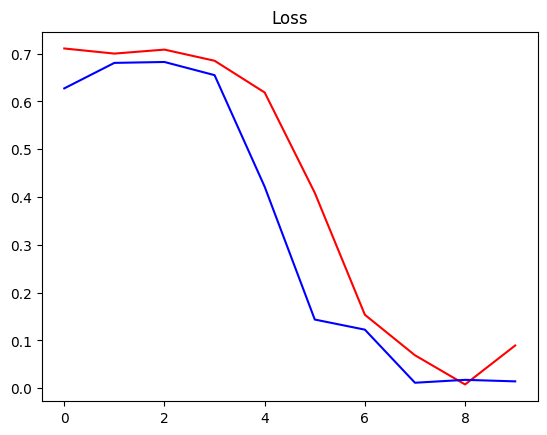

In [23]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

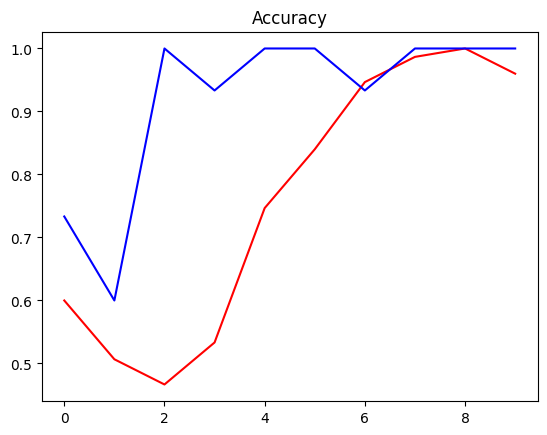

In [24]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

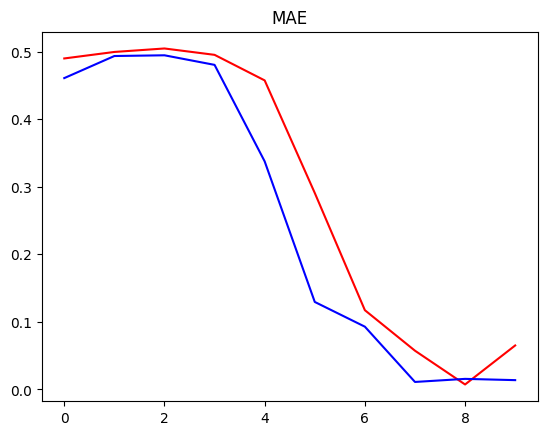

In [25]:
plt.title('MAE')
plt.plot(hist.history['mae'], 'r')
plt.plot(hist.history['val_mae'], 'b')
plt.show()

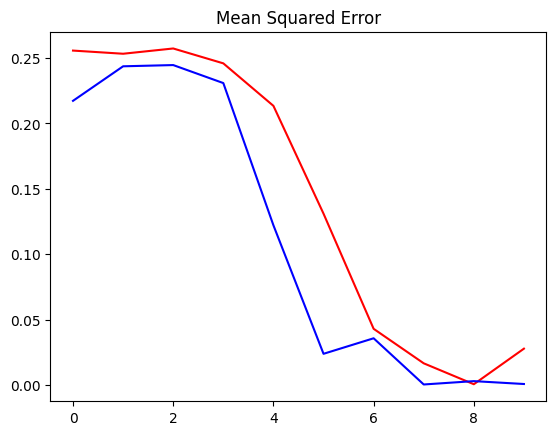

In [26]:
plt.title('Mean Squared Error')
plt.plot(hist.history['mean_squared_error'], 'r')
plt.plot(hist.history['val_mean_squared_error'], 'b')
plt.show()

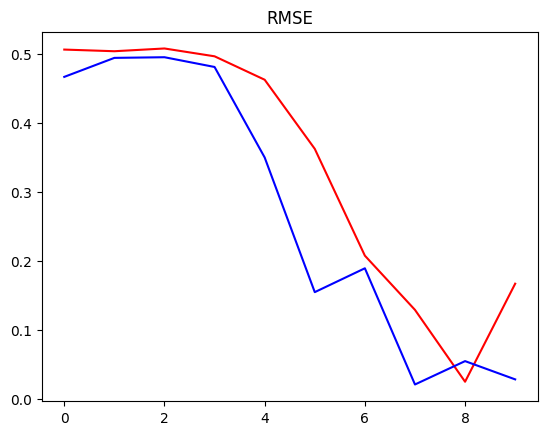

In [27]:
plt.title('RMSE')
plt.plot(hist.history['root_mean_squared_error'], 'r')
plt.plot(hist.history['val_root_mean_squared_error'], 'b')
plt.show()

In [29]:
model.save('models/mod_95.h5')

In [30]:
def load_image_for_test(filepath):
    img = tf.io.decode_jpeg(tf.io.read_file(filepath))
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, (80,80))
    img = img/255
    img = tf.convert_to_tensor(img)
    return img

In [33]:
y = tf.convert_to_tensor([load_image_for_test(closed_eyes[12])])

In [34]:
model.predict(y)[0][0]

1/1 [==============================] - 0s 22ms/step


0.9657251